In [8]:
import mne
import numpy as np
from scipy import stats
import seaborn as sns
import pandas as pd
import os
import re

# Multiprocessing
import deepgraph as dg
from multiprocessing import Pool
from nancorrmp.nancorrmp import NaNCorrMp
import matplotlib.pyplot as plt

%matplotlib inline



In [2]:
os.listdir("./DataBase")

['SETA', 'SETB', 'SETC', 'SETD']

In [38]:
def get_eeg_file(): 
  rootdir = "./DataBase/"
  sets = os.listdir(rootdir)
  regex = re.compile('(.*out$)')
  dic = []

  for set in sets: 
    for root, dirs, files in os.walk(rootdir+set):
      for file in files:
        if regex.match(file):
          ob = {
            "UID" : file[:-4],
            "set" : set, 
            "filename" : file,
          }
          dic.append(ob)
  return dic

In [201]:
mapping = {
    "SETA" : "HC", 
    "SETB" : "HC", 
    "SETC" : "AD",
    "SETD" : "AD"
}

channels = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2']

In [39]:
df = pd.DataFrame(get_eeg_file())
df.head()

,UID,set,filename
0,eeg20o1,SETA,eeg20o1.out
1,eeg21o1,SETA,eeg21o1.out
2,eeg22o1,SETA,eeg22o1.out
3,eeg23o1,SETA,eeg23o1.out
4,eeg24o1,SETA,eeg24o1.out


In [62]:
df["label"] = df["set"].map(mapping)
df.head()

,UID,set,filename,label
0,eeg20o1,SETA,eeg20o1.out,HC
1,eeg21o1,SETA,eeg21o1.out,HC
2,eeg22o1,SETA,eeg22o1.out,HC
3,eeg23o1,SETA,eeg23o1.out,HC
4,eeg24o1,SETA,eeg24o1.out,HC


In [44]:
n_features = 19
n_samples = len(df) 

X_raw = {} 

In [211]:
X_raw['eeg20o1'].shape

(1024, 19)

In [45]:
for _, s in df.iterrows(): 
    raw = np.loadtxt("DataBase\{}\{}".format(s["set"], s["filename"]))
    X_raw[s["UID"]] = raw 

In [54]:
X_corr = np.zeros((n_samples,n_features, n_features ))
p_corr = np.zeros(X_corr.shape)

X_corr.shape

(48, 19, 19)

In [55]:
for i, item in enumerate(X_raw.items()): 
    key, value = item
    corr, p = NaNCorrMp.calculate_with_p_value(value.T,  n_jobs=5)
    X_corr[i] += corr
    p_corr[i] += p

<AxesSubplot:>

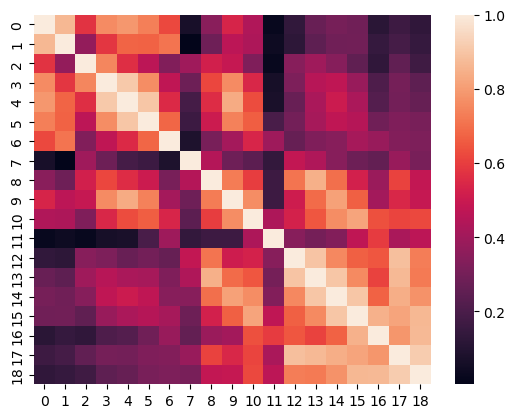

In [57]:
sns.heatmap(X_corr[0], )

In [187]:
df.head()

,UID,set,filename,label
0,eeg20o1,SETA,eeg20o1.out,HC
1,eeg21o1,SETA,eeg21o1.out,HC
2,eeg22o1,SETA,eeg22o1.out,HC
3,eeg23o1,SETA,eeg23o1.out,HC
4,eeg24o1,SETA,eeg24o1.out,HC


In [191]:
df_hc = df[df['label'] == 'HC']
df_ad = df[df['label'] == 'AD']

corr_hc = np.zeros((19,19))
corr_ad = np.zeros((19,19))


for _, s in df_hc.iterrows(): 
    raw = np.loadtxt("DataBase\{}\{}".format(s["set"], s["filename"]))
    corr, p = NaNCorrMp.calculate_with_p_value(raw.T,  n_jobs=5)
    corr_hc += corr

corr_hc = corr_hc/len(df_hc)


for _, s in df_ad.iterrows(): 
    raw = np.loadtxt("DataBase\{}\{}".format(s["set"], s["filename"]))
    corr, p = NaNCorrMp.calculate_with_p_value(raw.T,  n_jobs=5)
    corr_ad += corr

corr_ad = corr_ad/len(df_ad)

<AxesSubplot:>

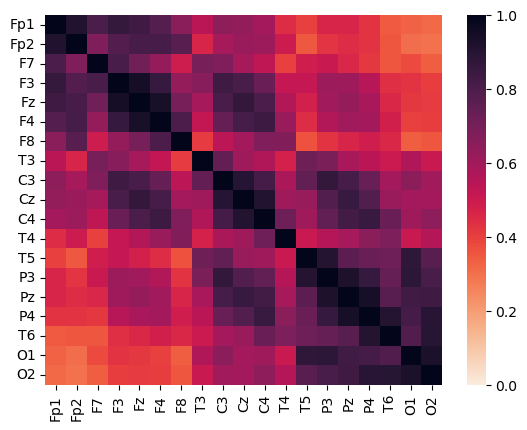

In [202]:
cmap = sns.cm.rocket_r

sns.heatmap(corr_hc, cmap=cmap, vmin=0, vmax=1, xticklabels=channels, yticklabels=channels)

<AxesSubplot:>

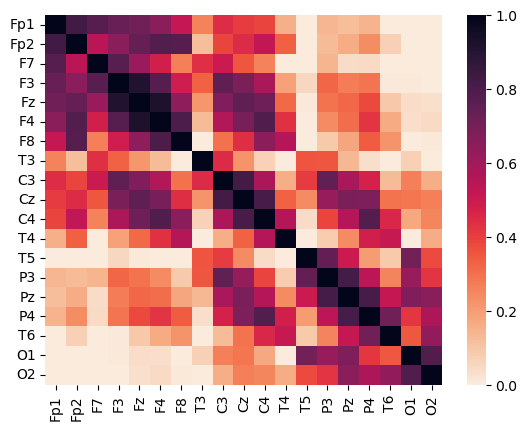

In [204]:
sns.heatmap(corr_ad, cmap=cmap, vmin=0, vmax=1, xticklabels=channels, yticklabels=channels)

<AxesSubplot:>

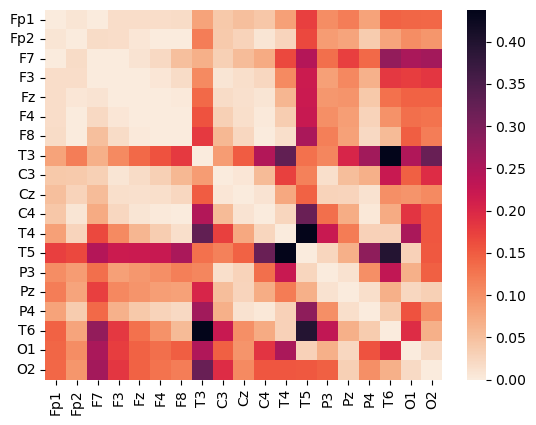

In [212]:
sns.heatmap((corr_hc-corr_ad)**2, cmap=cmap, xticklabels=channels, yticklabels=channels)

# Training

In [63]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix, classification_report

from torch.utils.data import Dataset


c:\Users\jimmy\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

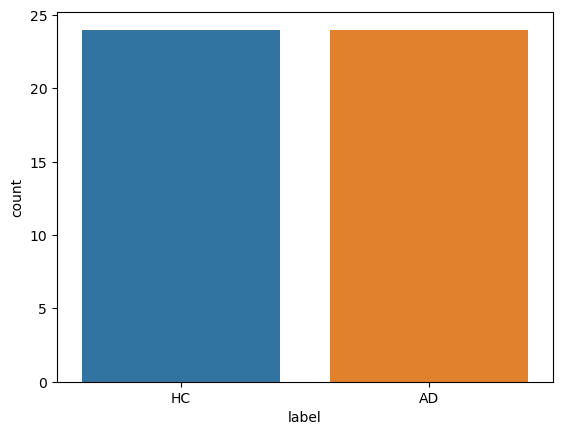

In [64]:
sns.countplot(df["label"])

In [69]:
Y = df["label"].to_numpy()

l_encoder = LabelEncoder()
i_encoded = l_encoder.fit_transform(Y)
print(i_encoded)

Y = i_encoded

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]


In [70]:
X = Variable(torch.from_numpy(X_corr.astype(np.float32)), requires_grad=False)
Y = Variable(torch.from_numpy(Y.astype(np.float32)), requires_grad=False)

In [71]:
X_train, X_test, y_train, y_test = train_test_split(   
     X, Y, test_size=0.2, random_state=42)

In [127]:
model = nn.Sequential(
          nn.Conv2d(1,16,3),
          nn.Conv2d(16,16,3),
          nn.MaxPool2d(2),
          nn.Dropout(),
          nn.Conv2d(16,32,3),
          nn.Conv2d(32,32,3),
          nn.MaxPool2d(3),
          nn.Dropout(),
          nn.Flatten(start_dim=0),
          nn.Dropout(),
          nn.Linear(32, 160),
          nn.ReLU(),
          nn.Linear(160, 1),
          #nn.Softmax(0)
        )
model.to("cuda")

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Dropout(p=0.5, inplace=False)
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (6): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.5, inplace=False)
  (8): Flatten(start_dim=0, end_dim=-1)
  (9): Dropout(p=0.5, inplace=False)
  (10): Linear(in_features=32, out_features=160, bias=True)
  (11): ReLU()
  (12): Linear(in_features=160, out_features=1, bias=True)
)

In [131]:
train_ds = torch.utils.data.TensorDataset(X_train, y_train)
validation_ds = torch.utils.data.TensorDataset(X_test, y_test)


train_ds_loader = torch.utils.data.DataLoader(train_ds,shuffle=True, batch_size=1)
test_ds_loader = torch.utils.data.DataLoader(validation_ds,shuffle=True)


def testAccuracy():
    
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in test_ds_loader:
            images, labels = data
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

In [132]:
import torch.optim as optim


loss_fn=nn.BCEWithLogitsLoss()
optimizer=optim.SGD(model.parameters(),lr=0.0001)

In [133]:
num_epoch = 100
train_losses=[]
valid_losses=[]

for epoch in range(1,num_epoch+1):
  train_loss=0.0
  valid_loss=0.0

  train_f1 =0.0
  train_acc = 0.0

  test_acc = 0.0 
  test_f1 = 0.0

  model.train()
  for img,lbl in train_ds_loader:
    img=img.cuda()
    lbl=lbl.cuda()
    #img=img.cpu()
    #lbl=lbl.cpu()

    optimizer.zero_grad()
    predict=model(img)
    loss=loss_fn(predict,lbl.flatten())
    loss.backward()
    optimizer.step()

    train_loss+=loss.item()*img.size(0)

    label = lbl.flatten().cpu()
    prediction = predict.cpu().detach().numpy()
    #print(prediction)
    train_acc += accuracy_score(label, prediction.round())
    train_f1 += 0#f1_score(label, prediction.round())

  model.eval()
  for img,lbl in test_ds_loader:
    img=img.cuda()
    lbl=lbl.cuda()
    #img=img.cpu()
    #lbl=lbl.cpu()

    predict=model(img)
    loss=loss_fn(predict,lbl.flatten())

    valid_loss+=loss.item()*img.size(0)

    label = lbl.flatten().cpu()
    prediction = predict.cpu().detach().numpy()

    test_acc += accuracy_score(label, prediction.round())
    test_f1 += 0#f1_score(label, prediction.round())

  train_loss=train_loss/len(train_ds_loader.sampler) 
  valid_loss=valid_loss/len(train_ds_loader.sampler)

  train_acc=train_acc/len(train_ds_loader.sampler)
  
  train_f1=train_f1/len(train_ds_loader.sampler)
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  test_acc=test_acc/len(train_ds_loader.sampler)


  print('Epoch:{} Train Loss:{:.4f} valid Losss:{:.4f} Train Accuracy:{:.4f} Train F1:{:.4f}  Test Accuracy:{:.4f} Test F1:{:.4f}'.format(epoch,train_loss,valid_loss, train_acc, train_f1,  test_acc, test_f1))    

Epoch:1 Train Loss:0.6948 valid Losss:0.1875 Train Accuracy:0.4474 Train F1:0.0000  Test Accuracy:0.1842 Test F1:0.0000
Epoch:2 Train Loss:0.6968 valid Losss:0.1875 Train Accuracy:0.4474 Train F1:0.0000  Test Accuracy:0.1842 Test F1:0.0000
Epoch:3 Train Loss:0.6934 valid Losss:0.1875 Train Accuracy:0.4474 Train F1:0.0000  Test Accuracy:0.1842 Test F1:0.0000
Epoch:4 Train Loss:0.6883 valid Losss:0.1876 Train Accuracy:0.4474 Train F1:0.0000  Test Accuracy:0.1842 Test F1:0.0000
Epoch:5 Train Loss:0.6809 valid Losss:0.1876 Train Accuracy:0.4474 Train F1:0.0000  Test Accuracy:0.1842 Test F1:0.0000
Epoch:6 Train Loss:0.6944 valid Losss:0.1876 Train Accuracy:0.4474 Train F1:0.0000  Test Accuracy:0.1842 Test F1:0.0000
Epoch:7 Train Loss:0.6958 valid Losss:0.1876 Train Accuracy:0.4474 Train F1:0.0000  Test Accuracy:0.1842 Test F1:0.0000
Epoch:8 Train Loss:0.6958 valid Losss:0.1876 Train Accuracy:0.4474 Train F1:0.0000  Test Accuracy:0.1842 Test F1:0.0000
Epoch:9 Train Loss:0.6837 valid Losss:0.

# 

# SVM

In [160]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
# param_grid={'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly']}


param_grid={'C':[1, 10, 100, 1000],'gamma':[0.001,0.0001],'kernel':['rbf','linear']}
svc=svm.SVC(probability=True)
model=GridSearchCV(svc,param_grid)

In [161]:
X_train_svm = X_train.reshape(38, 19*19)

X_test_svm = X_test.reshape(10, 19*19)

In [162]:
model.fit(X_train_svm,y_train)

GridSearchCV(estimator=SVC(probability=True),
             param_grid={'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                         'kernel': ['rbf', 'linear']})

In [173]:
y_pred=model.predict(X_train_svm)

accuracy_score(y_train, y_pred)


1.0

In [186]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train_svm,y_train)

y_pred = clf.predict(X_train_svm)

accuracy_score(y_train, y_pred)


1.0

In [167]:
labels = set(df["label"])
labels

{'AD', 'HC'}

In [168]:
tick_labels = labels
n_classes = len(labels)
def showClassficationReport(y_pred, y_true, top_n = 1):
    # Loop on each generator batch and predict

    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))

    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
                cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()
 
    class_report = classification_report(y_true, y_pred)
    return class_report

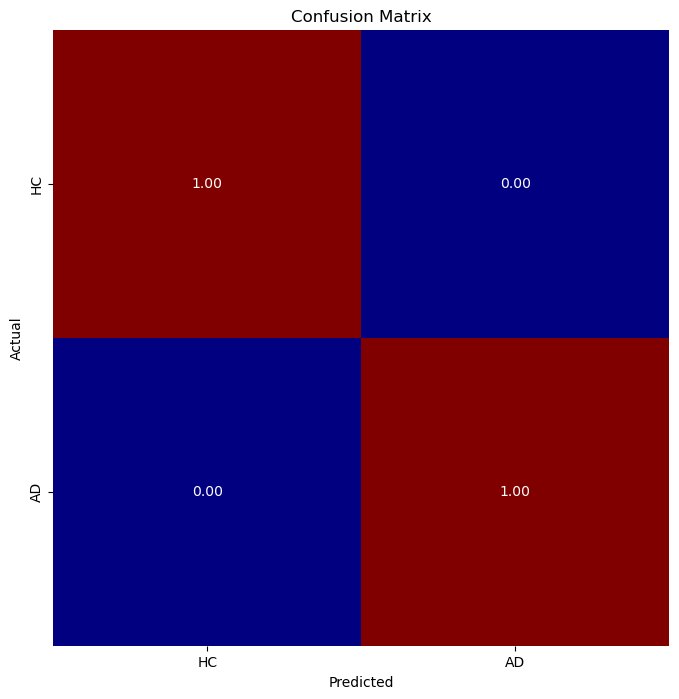

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         7
         1.0       1.00      1.00      1.00         3

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



In [169]:
class_report = showClassficationReport(y_pred , y_test)
print(class_report)

In [170]:
y_test

tensor([0., 0., 0., 0., 0., 0., 1., 1., 1., 0.])

In [171]:
y_pred  

array([0., 0., 0., 0., 0., 0., 1., 1., 1., 0.], dtype=float32)